In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Suppervised 🎯
## K Nearest Neighbour (K-NN)
Base on the intuition that when a test datapoint, $x_*$, is 'close' to a training datapoint, $x_i$, then the prediction, $\hat{y}(x_*)$, should be close to $y_i$. Distance is commonly done in euclidean space where $||x_i-x_*||=\sqrt{(x_{i0}-x_{*0})^2+\ldots+(x_{ip}-x_{*p})^2}$, though different measures can be used to achieve different behaviours. The prediction is then calculated as $\hat{y}(x_*)=\frac{1}{|N_*|}\sum_{j\in N_*}y_j$ for the regression problem and $\hat{y}(x_*)=\text{MajorityVote}\{y_j:j\in N_*\}$ for the classification problem; where $N_*$ is the set of the $k$ 'closest' datapoints to $x_*$.

This method is sensitive to feature weightings, requiring all to be of the same magnitude in order to not have features' behaviour obscured by others. These are commonly done by transforming the dataset into $x_{ij}'=\frac{x_{ij}-\max_{\cdot j}}{\max_{\cdot j}-\min_{\cdot j}}$ (classical) and $x_{ij}'=\frac{x_{ij}-\mu_{\cdot j}}{\sigma_{\cdot j}}$ (normal).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

## Decision Trees
This model systematically creates a set of rules that partitions the feature space explicitly, organised into a binary tree structure; allowing for prediction through its traversal. For each resultant partition, $R_l$, a constant value prediction is used $\hat{y}(x_*)=\sum_{l\in L}\hat{y_l}\mathbb{I}_{x_*\in R_l}$. The recursive splitting occurs where any given region $R_l'$ is partitioned based on a feature, $j$, and a threshold, $s$, resulting in two child regions $R_l(j,s)=\{x|x_j<s\}$ and $R_{\bar{l}}(j,s)=\{x|x_j\geq s\}$; their subsequent prediction values are then $\hat{y_l}(j,s)=\frac{1}{|R_l(j,s)|}\sum_{x_i\in R_l(j,s)}y_i$ (regression) or $\hat{y_l}(j,s)=\text{MajorityVote}\{y_i:x_i\in R_l(j,s)\}$ (classification). Finding the best feature-threshold pairs requires a weighted sum of the created regions, $\text{Error}_l(j,s)=\frac{|R_l(j,s)|}{|R_l'|}\text{Error}(R_l(j,s))+\frac{|R_{\hat{l}}(j,s)|}{|R_l'|}\text{Error}(R_{\hat{l}}(j,s))$. Measuring the region's independent error depends on the prediction task:

<table><tr><td>Classification</td><td>Regression</td></tr>
<tr><td>

$\text{Gini}(R)=1-\sum_{k=1}^K{p_k}^2$ where $p_k$ is the proportion of class $k$ in the region $R$, measures how often a randomly selected sample would be mislabeled if assigned by class proability.
</td><td>

$\text{MeanSquareError}(R)=\frac{1}{|R|}\sum_{x_i\in R}(y_i-\overline{y_R})^2$
</td></tr>
<tr><td>

$\text{Entropy}(R)=-\sum_{k=1}^Kp_k\log_2(p_k)$ where $p_k$ is the proportion of class $k$ in the region $R$, measures the uncertainty/disorder in a region's class distribution.
</td><td>

$\text{MeanAbsoluteError}(R)=\frac{1}{|R|}\sum_{x_i\in R}|y_i-\overline{y_R}|$ is a more robust measure than MSE
</td></tr>
</table>

Repeating these measures for (subset of) all possible values for $j=1,\ldots,p$ and $s$, the optimal split can be found. As the process repeats, the depth of the tree increases and by-extension the overfitting of the model onto the training data.

In [ ]:

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
    criterion="gini",     # or "entropy", "log_loss"
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Random Forest
This model applies the general technique of ***bootstrap aggregation*** to decision tree learners. Given a training set $T=\{x_i,y_i\}_{i=1}^n$, this procedure repeatedly ($B$ times) selects a random sample (of size $n$) with replacement of the training set and fits a decision tree model to it. After training, a prediction is formed from the aggregated predictions $\hat{y_{\text{bag}}}(x_*)=\frac{1}{B}\sum_{b=1}^{B}\tilde{y}^{(b)}(x_*)$.
- $\tilde{y}^{(b)}(x_*)$ are identically distributted but correlated as the base models used to predict them originate from the same dataset; thus, considering $z_1,\ldots,z_B$ identically distributed random variables with $\mathbb{E}[z_b]=\mu$ and $\text{Var}(z_b)=\sigma^2$ with an average correlation between any pair of variables as $\rho$, then $\mathbb{E}[\frac{1}{B}\sum_{b=1}^{B}z_b]=\mu$ and $\text{Var}[\frac{1}{B}\sum_{b=1}^{B}z_b]=\frac{1-\rho}{B}\sigma^2+\rho\sigma^2$. This means that as $B\rightarrow\infty$ then $\text{Var}[\frac{1}{B}\sum_{b=1}^{B}z_b]\rightarrow \rho\sigma^2$.

Bootstrapping allows for Out-of-Bag error estimation as practically, each sample of the training set  will contain ~63% of the original datapoints. Therefore, for each datapoint $\{x_i,y_i\}$, the error score $E^{(i)}_{\text{OOB}}$ can be calculated on ~33% of predictors; and so resulting in $E_{\text{OOB}}=\frac{1}{n}\sum_{i=1}^nE^{(i)}_{\text{OOB}}$. This is a good estimate for an ensemble model with only $B/3$ members and so if the performance of ensembles of size $B$ and $B/3$ perform similarly then it is at least as good as a k-fold error score.

### eXtreme Gradient Boosting (XGBoost)
This model applies the general technique of ***Gradient Boosting***, where the ensemble members are sequential constructed to improve the accuracy (or other scoring function) of the previous' member. Once constructed, their combined weighted functions are used to form a robust, deterministic prediction model.

In XGBoost, this is done through its ***objective function*** (function to be optimised) $$\mathcal{L}(\phi)=\sum_{i=1}^n{[l(y_i,\hat{y_i}^{(t)})+\sum_{k=1}^t\Omega(f_k)]}$$

where $l(y_i,\hat{y_i}^{(t)})$ is any differentiable convex loss function that measures the difference between the prediction, $\hat{y_i}^{(t)}$ (for the ensemble member $t$),  and the target $y_i$. $\Omega(f_k)$ is a complexity penalising term used to ensure that the final learnt weights avoid overfitting. Typically, $\Omega(f)=\gamma T+\frac{\lambda}{2}\sum_{j=1}^T{w_j}^2$ where $T$ is the number of leaves in the tree, $w_j$ are the score of each leaf, and $\gamma,\lambda$ are regularization parameters. At any stage of the Gradient Boosting, the predicted value is defined as $\hat{y_i}^{(t)}=f_0(x_i)+f_1(x_i)+\ldots+f_t(x_i)=\hat{y_i}^{(t-1)}+f_t(x_i)$ and so $\mathcal{L}^{(t)}=\sum_{i=1}^n{l(y_i,\hat{y_i}^{(t-1)}+f_t(x_i))+\Omega(f_t)}$. 

Applying the ***Taylor expansion*** to the loss function results in $\mathcal{L}^{(t)}\approx\sum_{i=1}^n[l(y_i,\hat{y_i}^{(t-1)})+\frac{\partial l(y_i,\hat{y_i}^{(t-1)})}{\partial \hat{y_i}^{(t-1)}}f_t(x_i)+\frac{1}{2}\frac{\partial^2 l(y_i,\hat{y_i}^{(t-1)})}{\partial (\hat{y_i}^{(t-1)})^2}f_t(x_i)^2]+\Omega(f_t)$, and the constants (in terms of $f_t$) can be removed resulting in $\tilde{\mathcal{L}}^{(t)}\approx\sum_{i=1}^n[\frac{\partial l(y_i,\hat{y_i}^{(t-1)})}{\partial \hat{y_i}^{(t-1)}}f_t(x_i)+\frac{1}{2}\frac{\partial^2 l(y_i,\hat{y_i}^{(t-1)})}{\partial (\hat{y_i}^{(t-1)})^2}f_t(x_i)^2]+\Omega(f_t) = \sum_{i=1}^n[\frac{\partial l(y_i,\hat{y_i}^{(t-1)})}{\partial \hat{y_i}^{(t-1)}}f_t(x_i)+\frac{1}{2}\frac{\partial^2 l(y_i,\hat{y_i}^{(t-1)})}{\partial (\hat{y_i}^{(t-1)})^2}f_t(x_i)^2] + \gamma T+\frac{\lambda}{2}\sum_{j=1}^T{w_j}^2$.

As each leaf $j$ assigns a constant weight $w_j$, and each training point falls into exactly one leaf; instead of $f_t(x_i)=w_j$ for $i\in I_j$ can be used. Then it can be rewritten as $\tilde{\mathcal{L}}^{(t)}=\sum_{j=1}^T\sum_{i\in I_j}(\frac{\partial l(y_i,\hat{y_i}^{(t-1)})}{\partial \hat{y_i}^{(t-1)}}w_j+\frac{1}{2}\frac{\partial^2 l(y_i,\hat{y_i}^{(t-1)})}{\partial (\hat{y_i}^{(t-1)})^2}{w_j}^2) + \gamma T+\frac{\lambda}{2}\sum_{j=1}^T{w_j}^2$ which means that the optimal weights: $$w_j^*=\frac{-\sum_{i\in I_j}\frac{\partial l(y_i,\hat{y_i}^{(t-1)})}{\partial \hat{y_i}^{(t-1)}}}{\sum_{i\in I_j}\frac{\partial^2 l(y_i,\hat{y_i}^{(t-1)})}{\partial (\hat{y_i}^{(t-1)})^2}+\lambda}\rightarrow \tilde{\mathcal{L}}^{(t)*}=-\frac{1}{2}\sum_{j=1}^{T}\frac{(\sum_{i\in I_j}\frac{\partial l(y_i,\hat{y_i}^{(t-1)})}{\partial \hat{y_i}^{(t-1)}})^2}{\sum_{i\in I_j}\frac{\partial^2 l(y_i,\hat{y_i}^{(t-1)})}{\partial (\hat{y_i}^{(t-1)})^2}+\lambda}+\gamma T$$

This is then used as a scoring function to measure the quality of a tree structure (similar to impurity score). Beginning from a single leaf and iteratively adds branches; the splitting criteria is then defined by maximising the gain function (objective function of left and right children compared to the parent's), $\text{Gain}=\tilde{\mathcal{L}}^{(t)*}(L)+\tilde{\mathcal{L}}^{(t)*}(R)-\tilde{\mathcal{L}}^{(t)*}(P)$. A split is only accepted if $\text{Gain}>0$, otherwise the branch is not expanded further; if there are no more expandable branches, the tree is completed and a new tree is initiated.

In [ ]:
import xgboost as xgb

clf = xgb.XGBClassifier(
    n_estimators=1000,        # large number + early stopping
    learning_rate=0.05,       # eta
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,           # L2
    reg_alpha=0.0,            # L1
    gamma=0.0,                # min loss reduction to split (a.k.a. min_split_loss)
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    tree_method="hist"        # fast; try "gpu_hist" if GPU
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False,
    early_stopping_rounds=50,  # stops when no improvement
)

pred_proba = clf.predict_proba(X_valid)[:, 1]

#### Categorical Boosting (CatBoost)
*XGBoost*, like other models, commonly use *target encoding* for categorical features; defining $\hat{y}^{(k)}=\mathbb{E}(y|x_i=x^{(k)}_i)$, the average target values over the training examples with the same categories. However, this is noisy for low-frequency targets and so it is usually smoothed using $x^{(k)}_i=\frac{\sum_{j=1}^n\mathbb{I}_{x^{(k)}_i=x^{(k)}_j}y_j+ap}{\sum_{j=1}^n\mathbb{I}_{x^{(k)}_i=x^{(k)}_j}+a}$ where $a>0$ is a pre-defined parameter, adn $p$ is a prior (global mean, etc.).

Because feature $\hat{x}^{(k)}_i$ is computed using $y_i$, as well as using 'future' records, these lead to a *conditional shift* (target leakage); where the distribution of $\hat{x}^{(k)}|y$ differs between the training and testing conditions.

A general method to avoid the first issue is defining a *Leave-One-Out* (LOO) subsets, $\mathcal{D}_i\sub\mathcal{D}\backslash \{x_i\}$, which exclude the given datapoint. This leads to the new definition $x^{(k)}_i=\frac{\sum_{x_j\in\mathcal{D}_i}\mathbb{I}_{x^{(k)}_i=x^{(k)}_j}y_j+ap}{\sum_{x_j\in\mathcal{D}_i}\mathbb{I}_{x^{(k)}_i=x^{(k)}_j}+a}$. However, this leaves the use of 'future' records in the evaluation of the datapoint, and so conditional shift remains.

*CatBoost* uses a more effective, *Ordered/Online*, strategy; generating $s+1$  idependent random permutations (random orderings) of the training dataset. Permutations $\sigma_1,\ldots,\sigma_s$ are used for evaluation of splits that define $s$ tree tructures (gradient computation), and thus stabilizes the estimates; while $\sigma_0$ is used for obtaining th eleaf values of hte obtained trees.

This way, each permutation, $\sigma_a=\{\pi_{1},\pi_{2},\ldots,\pi_{n}\}$, allows for the definition of $\text{Prefix}_a(i)=\{\pi_{j}\in\sigma_a:j<i\}$ and so $$x^{(k)}_i=\frac{\sum_{x_j\in\text{Prefix}(i)}\mathbb{I}_{x^{(k)}_i=x^{(k)}_j}y_j+ap}{\sum_{x_j\in\text{Prefix}(i)}\mathbb{I}_{x^{(k)}_i=x^{(k)}_j}+a}$$

This ensures only the labels of samples that came prior to the given feature (excluding itself) in the permutation are used; preventing conditional shift between test and training scenarios.


This mechanism allows for *Catboost* to natively and safely handle categorical and text-based features without requiring external preprocessing or encoding. In addition, CatBoost avoids the complex, arbitrarily-shaped trees used in algorithms like XGBoost. Instead, it uses *symmetric* (oblivious) trees, where all nodes at the same depth split on the same feature and threshold. This design offers efficient parallelisation due to the model's regular and predictable structure, as well as fast inference due to the constant depth procedures aligning with modern hardware architecture and behaviour.

In [ ]:
from sklearn.datasets import fetch_openml
from catboost import CatBoostClassifier, Pool

mush = fetch_openml(name="mushroom", version=1, as_frame=True)
df = mush.frame.copy()
df['class'] = (df['class'] == 'p').astype(int)
X = df.drop(columns=['class'])
y = df['class']

cat_features = list(range(X.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
test_pool  = Pool(X_test,  label=y_test,  cat_features=cat_features)

model = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=False)
model.fit(train_pool)

preds = model.predict(test_pool).ravel().astype(int)

## Probabilistic Regression
### Natural Gradient Boosting (NGBoost)

# Unsupervised 🧩
## Clustering ✨
### K-Means Clustering

### Density-based Spatial Clustering of Applications with Noise (DBSCAN)
Similar 

<table>
<tr><td>

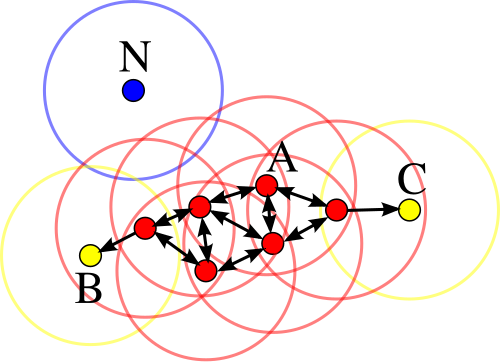

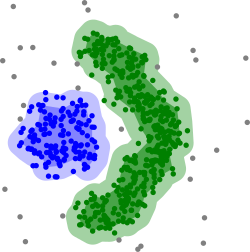
</td><td>

A point $p$ is a *core* node if at least $k$ points are within $\varepsilon$ distance of it, $\mathbb{I}_{x_i\in\mathcal{C}}=k\geq \sum_{x_j\in X\backslash\{x_i\}}\mathbb{I}_{\varepsilon\leq\text{D}(x_i,x_j)}$, and a point $q$ is *directly reachable* from $p$ if its within a distance $\varepsilon$ form it. It is *reachable* from $p$ there exists a sequence $p_0,p_1,\ldots,p_n$ where $p_0=p$, $p_n=q$ and $p_{i+1}$ is *directly reachable* from $p_i$. *Outliers* are points not *reachable* from any other point.
</td></tr>
</table>

Starting at an arbitrary *core* point $p$, a cluster is expanded by adding all points that are *directly reachable* from $p$; this includes both *core* and non-core points. For every newly added *core* point, this expansion process continues recursively until no further points are *reachable*, and the cluster has been fully explored.

Once the cluster has been exhausted, a new unvisited *core* point (one that does not yet belong to any discovered cluster) is selected, and the same expansion process is applied to form the next cluster.

The algorithm terminates when every point has been assigned either to a cluster or is an *outlier*. Unlike *K‑means Clustering*, *DBSCAN* is deterministic; given the same data and the same parameters, $(\varepsilon,k)$, it will always produce the same clusters and the same set of *outliers*, regardless of how many times the algorithm is run.

### Support Vector Data Description (SVDD)
### Kernel Density Estimation (KDE)
## Outlier Detection 🚨
### One-class SVM
### Support Vector Data Description (SVDD)
### Isolation Forest (iF)
## Dimensionality Reducion 🌀

# Neural Networks 🧠
## Multi-Input NN
### Multi-Output NN
## Encoder Decoder (ED) NN
### Auto-Encoder
## Recurrent NN (RNN)
## Long Short-Term Memory (LSTM) NN
## Gater Recurrent Unit (GRU) NN
## Natural Language Processing
### Text Embedding 🗺️
### Attention Mechanism
#### Transformers 🤖
### Retrieval Augmented Generation (RAG) 🗃️
## Convolutional NN (CNN) 
### Bounding Box
### Image Segmentation
#### Semantic Segmentation
#### Instance Segmentation
#### Panoptic Segmentation
## Generative Adversarial Network (GAN)

# Graph ML 🕸️